<a href="https://colab.research.google.com/github/muthuv11/NLP_lily/blob/master/NLP_caseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
To predict the sentiment from the provided twitter tweet dataset.

6+1 features provided.

tweet_id, name, text, tweet_created, tweet_location, user_timezone - sentiment

# Assumptions

Supervised model

# Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import numpy as np
import re
import nltk
import spacy


from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


#validation
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report

from gensim.models import word2vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV

!pip install contractions
!pip install textsearch

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import contractions

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Loading

In [0]:
df = pd.read_csv('/content/Data.csv')

In [3]:
df.head()

,tweet_id,sentiment,name,text,tweet_created,tweet_location,user_timezone
0,1,neutral,cairdin,What @dhepburn said.,24/02/15 11:35,NaN,Eastern Time (US & Canada)
1,2,positive,jnardino,plus you've added commercials to the experienc...,24/02/15 11:15,NaN,Pacific Time (US & Canada)
2,3,neutral,yvonnalynn,I didn't today... Must mean I need to take ano...,24/02/15 11:15,Lets Play,Central Time (US & Canada)
3,4,negative,jnardino,"it's really aggressive to blast obnoxious ""ent...",24/02/15 11:15,NaN,Pacific Time (US & Canada)
4,5,negative,jnardino,and it's a really big bad thing about it,24/02/15 11:14,NaN,Pacific Time (US & Canada)


# Data Descriptive Analysis

Data shape & % of Missing values

In [4]:
print("Dataset shape",df.shape)
print("% of Null values \n", (df.isna().sum()/len(df))*100)

Dataset shape (14640, 7)
% of Null values 
 tweet_id           0.000000
sentiment          0.000000
name               0.000000
text               0.000000
tweet_created      0.000000
tweet_location    32.329235
user_timezone     32.923497
dtype: float64


Check for duplicate data

In [5]:
def chk_duplicate_clean():
    dup = df[df.duplicated()].copy()
    print('duplicate observations- ', dup.shape[0])
    df.drop_duplicates(keep='first',inplace=True) 
    if dup.shape[0] >0 :
          return dup

chk_duplicate_clean()

duplicate observations-  0


Check for class balance

negative    9178
neutral     3099
positive    2363
Name: sentiment, dtype: int64


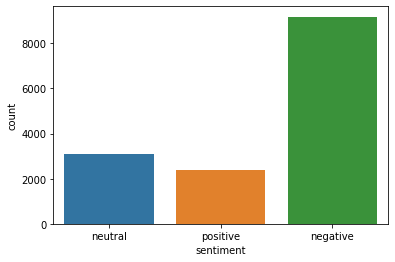

In [6]:
def chk_classBalance(target_col):
    print(df[target_col].value_counts())
    sns.countplot(df[target_col])

chk_classBalance('sentiment')

In [7]:
df.dtypes

tweet_id           int64
sentiment         object
name              object
text              object
tweet_created     object
tweet_location    object
user_timezone     object
dtype: object

# Data pre-Processing

In [0]:
# remove accented character
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
  
# Remove special charcters
def remove_special_characters(text):
      # remove special characters, numbers, punctuations
      pattern = r'[^a-zA-Z#\s]'
      text = re.sub(pattern, '', text)
      return text

# function to collect hashtags
def extract_hashtags(text):
    tags = (re.findall(r"#(\w+)", text))
    return len(tags)

# Remove special charcters
def replace_tags(text):
      text = re.sub('#', '', text)
      return text
  
# Expand contractions
def expand_contractions(text):
  text = contractions.fix(text)
  return text

# no of bold words
def extract_bolds(text):
    tags = (re.findall(r"(A-Z+)", text))
    return tags

# Remove stop words and word size <3
def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token in tokens if (token not in stopwords and len(token) >=3)]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Remove urls
def remove_urls(text):
    no_urlText = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    return no_urlText 

# Lower casing of tweets
def covert_lowerCase(text):
  text = text.lower()
  return text

# Lemmatize text
def lemmatize_text(text):
    word_tokens = word_tokenize(text)
    wl= WordNetLemmatizer()
    text = ' '.join([wl.lemmatize(word, pos="v") for word in word_tokens])
    return text


In [0]:
#remove_accented_chars('Sómě Áccěntěd těxt')
#remove_special_characters('hshs #jsj k12 13 #@ !$')
#extract_hashtags ('hshs #jsj k12 13 @ !$')
#replace_tags('hshs #jsj k12 13 #@ !$')
#remove_contractions('''plus you've added commercials to the experience... tacky.''')
#re.findall(r"#(\w+)", 'sjdadnsd @sd ksksk')
#extract_bolds('sjda AS a')
#remove_stopwords ('Hi hello are you a friend of mr.jja can you please help yourself in finding a seat in room 23')
#spacy_lemmatize_text('Hi running changing taken harder')
#lemmatize_text ('Hi running changing taken baggage')



In [9]:
df = pd.read_csv('/content/Data.csv')
cols = ['tweet_id','name', 'tweet_created', 'tweet_location', 'user_timezone']
df = df.drop(columns=cols,axis=1)

df['tidy_text'] = np.vectorize(remove_accented_chars)(df['text'])
df['tidy_text'] = np.vectorize(remove_special_characters)(df['tidy_text'])
df['no_tags'] = np.vectorize(extract_hashtags)(df['text'])
df['tidy_text'] = np.vectorize(replace_tags)(df['tidy_text'])
df['tidy_text'] = np.vectorize(expand_contractions)(df['tidy_text'])
df['tidy_text'] = df.tidy_text.apply(remove_stopwords)
df['tidy_text'] = df.tidy_text.apply(remove_urls)
df['tidy_text'] = df.tidy_text.apply(covert_lowerCase)
df['tidy_text'] = df.tidy_text.apply(lemmatize_text)
df.head()

,sentiment,text,tidy_text,no_tags
0,neutral,What @dhepburn said.,what dhepburn say,0
1,positive,plus you've added commercials to the experienc...,plus add commercials experience tacky,0
2,neutral,I didn't today... Must mean I need to take ano...,today must mean need take another trip,0
3,negative,"it's really aggressive to blast obnoxious ""ent...",really aggressive blast obnoxious entertainmen...,0
4,negative,and it's a really big bad thing about it,really big bad thing,0


# Visualization - cross check pre-processing

In [0]:
positive_tweets= ' '.join(df.tidy_text[df['sentiment']=='positive'])
negative_tweets= ' '.join(df.tidy_text[df['sentiment']=='negative'])
neutral_tweets= ' '.join(df.tidy_text[df['sentiment']=='neutral'])

In [0]:
def generate_wordcloud(text_data):
    wordcloud = WordCloud(background_color= "white").generate(text_data)
    plt.figure(figsize = (15,15))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

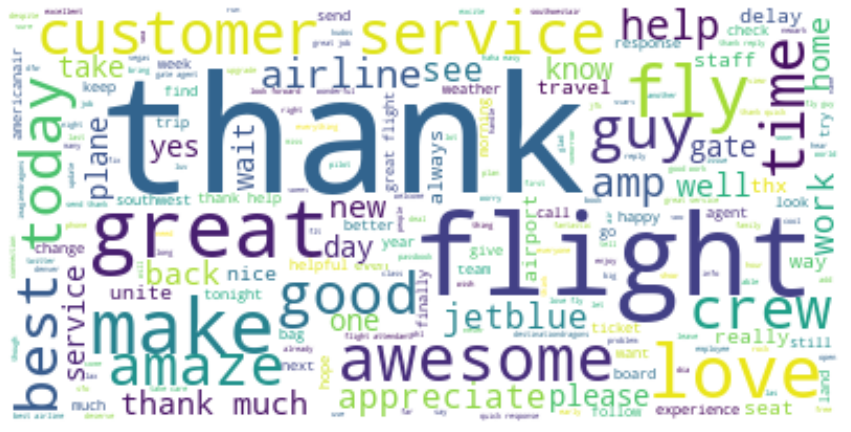

In [12]:
generate_wordcloud(positive_tweets)

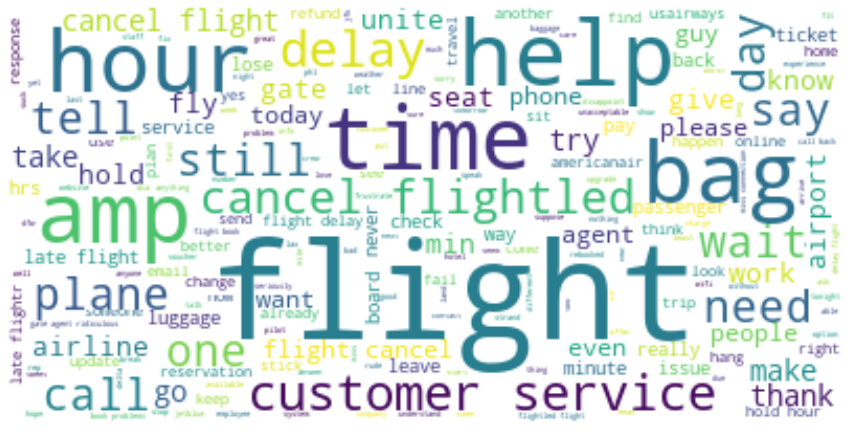

In [13]:
generate_wordcloud(negative_tweets)

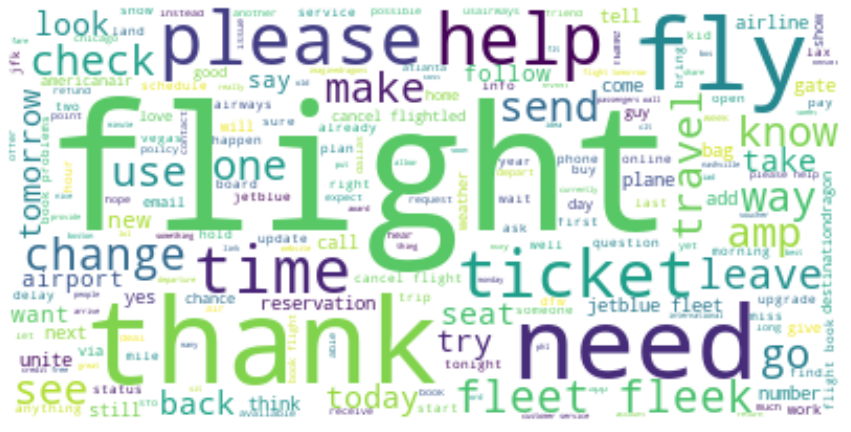

In [14]:
generate_wordcloud(neutral_tweets)

In [0]:
cols = ['text', ]
df = df.drop(columns=cols,axis=1)

In [0]:
cols = ['no_tags', ]
df = df.drop(columns=cols,axis=1)

In [17]:
df.head()

,sentiment,tidy_text
0,neutral,what dhepburn say
1,positive,plus add commercials experience tacky
2,neutral,today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainmen...
4,negative,really big bad thing


# Vectorization
**Tf-Idf**

In [0]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000)

**Word2Vec**

In [0]:
def tokenization(text):
  tokens = nltk.word_tokenize(text)
  return tokens

preprocessed_text = df.tidy_text.apply(tokenization)

In [0]:
#w2v model
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words
w2v_model = word2vec.Word2Vec(preprocessed_text, size=feature_size,window=window_context, min_count = min_word_count,sample=sample, iter=100)

In [0]:
#vectorizing the dataset tweets
def average_word_vectors(words, model, vocabulary, num_features): 
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)       
    return feature_vector
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [23]:
# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=preprocessed_text, model=w2v_model,
                                             num_features=feature_size)
X_w2v_model = pd.DataFrame(w2v_feature_array)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [24]:
X_w2v_model.shape

(14640, 10)

# Model Training

In [0]:
Xcols= ['tidy_text']
# Get training and validation data
X_train, X_val, y_train, y_val = train_test_split(df[Xcols],df['sentiment'],test_size=0.2,random_state=42)


In [0]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000)
# TF-IDF feature matrix
tfidf_train = tfidf_vectorizer.fit_transform(X_train['tidy_text'])
tfidf_test = tfidf_vectorizer.transform(X_val['tidy_text'])
tfidf_df = tfidf_vectorizer.fit_transform(df['tidy_text'])

In [0]:
lencod = LabelEncoder()
# fit_transform() converts the text to numbers
df.sentiment = lencod.fit_transform(df.sentiment)

In [0]:
y = df.sentiment
X_train_wm, X_test_wm, y_train_wm, y_test_wm = train_test_split(X_w2v_model, y, test_size=0.2, random_state=42)

In [0]:
def train_model(clf,X, y, val_x, val_y):
    model = clf
    #t1 = time()
    model.fit(X, y)
    #t2 = round((t1-time()), 3)
    #t3 = time()
    pred = model.predict(val_x)
    #t4 = round((t3-time()), 3)
    score = accuracy_score(pred, val_y)
    cross_score = cross_val_score(clf, X, y, scoring='accuracy', cv = 10)
    
    print("Model : %s" % clf)
    #print("Training Time : %d" % t2)
    #print("Prediction Time : %d" % t4)
    print("Accuracy : %s" % score)
    print("Cross_Val_Score : %s" % cross_score.mean())
    labels = ['negative', 'neutral','positive']
    print(classification_report(val_y, pred))
    print(pd.DataFrame(confusion_matrix(val_y, pred), index=labels, columns=labels))
   
 

In [33]:
clf2 = MultinomialNB()
train_model(clf2, tfidf_train, y_train, tfidf_test, y_val)

Model : MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Accuracy : 0.7421448087431693
Cross_Val_Score : 0.7260069862402836
              precision    recall  f1-score   support

           0       0.74      0.98      0.84      1889
           1       0.66      0.23      0.34       580
           2       0.88      0.43      0.58       459

    accuracy                           0.74      2928
   macro avg       0.76      0.54      0.59      2928
weighted avg       0.74      0.74      0.70      2928

          negative  neutral  positive
negative      1844       37         8
neutral        431      131        18
positive       229       32       198


In [34]:
clf1 = RandomForestClassifier()
train_model(clf1, tfidf_train, y_train, tfidf_test, y_val)

Model : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy : 0.7773224043715847
Cross_Val_Score : 0.7546088200919258
              precision    recall  f1-score   support

           0       0.82      0.92      0.86      1889
           1       0.64      0.45      0.53       580
           2       0.72      0.62      0.67       459

    accuracy                           0.78      2928
   macro avg       0.72      0.66      0.68      2928
weighted avg       0.76      0.78      0.77      292

In [35]:
from sklearn.svm import SVC
clf3 = SVC()
train_model(clf3, tfidf_train, y_train, tfidf_test, y_val)

Model : SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy : 0.7855191256830601
Cross_Val_Score : 0.7697231589347805
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1889
           1       0.67      0.42      0.51       580
           2       0.80      0.64      0.71       459

    accuracy                           0.79      2928
   macro avg       0.76      0.66      0.70      2928
weighted avg       0.78      0.79      0.77      2928

          negative  neutral  positive
negative      1763       88        38
neutral        302      241        37
positive       130       33       296


In [36]:
clf3 = SVC()
train_model(clf3, X_train_wm, y_train_wm, X_test_wm, y_test_wm)

Model : SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy : 0.7575136612021858
Cross_Val_Score : 0.7421441957662859
              precision    recall  f1-score   support

           0       0.78      0.94      0.86      1889
           1       0.63      0.39      0.48       580
           2       0.72      0.46      0.56       459

    accuracy                           0.76      2928
   macro avg       0.71      0.60      0.63      2928
weighted avg       0.74      0.76      0.73      2928

          negative  neutral  positive
negative      1784       75        30
neutral        304      225        51
positive       191       59       209


# Model Optimization

In [37]:
#model parameter grid
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(clf3,param_grid,refit=True,verbose=2)
grid.fit(tfidf_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   9.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   9.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   9.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   9.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   9.2s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  12.5s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  12.5s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  12.5s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 35.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [38]:
print(grid.best_estimator_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [0]:
best_model = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [40]:
train_model(best_model, tfidf_train, y_train, tfidf_test, y_val)

Model : SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Accuracy : 0.7882513661202186
Cross_Val_Score : 0.7743333634506255
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1889
           1       0.63      0.52      0.57       580
           2       0.75      0.67      0.71       459

    accuracy                           0.79      2928
   macro avg       0.74      0.70      0.71      2928
weighted avg       0.78      0.79      0.78      2928

          negative  neutral  positive
negative      1699      137        53
neutral        228      301        51
positive       109       42       308


In [0]:
#visalization & summarization

In [0]:
!pip install datefinder

In [0]:
import datefinder



In [0]:
text = '26th Jan is the republic day for india and the date of birth in 2013/4/1 also first week of august 2021'
matches = datefinder.find_dates(text)

for match in matches:
  print(match)